# RDKit: substructure queries using SMARTS

This notebook explores using `RDKit` to find matching 2D structures in organic molecules, using SMARTS queries.  It uses RDKit's very nice structure renderer to show matches.  This notebook isn't a replacment for the [rdkit documentation](http://www.rdkit.org/docs/), but is intended to complement it.

@TAGS: #basics #substructure-queries

In [1]:
from __future__ import print_function
# import rdkit components
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# use IPythonConsole for pretty drawings
from rdkit.Chem.Draw import IPythonConsole

## The next line is commented out 
### because GitHub does not render svg's embedded in notebooks
# IPythonConsole.ipython_useSVG=True

# Defining and viewing a small set of example molecules

In [4]:
# some heterocycles 
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene, 
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline,
               ]

Our test molecules for this notebook will be the arbitrary set of heterocycles and homocycles (and benzene) above.  

It's easy to get a look at the structure of these molecules.

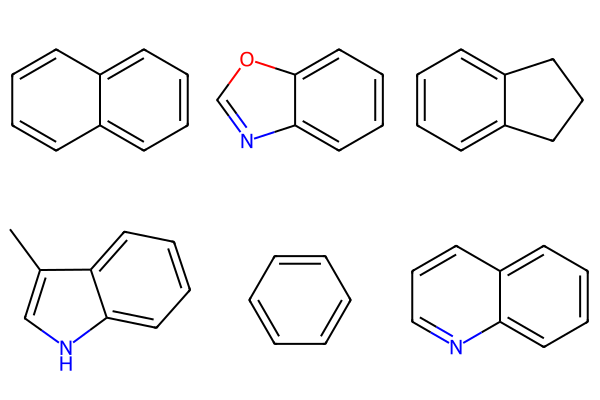

In [5]:
Draw.MolsToGridImage(my_molecules, useSVG=False)

For `RDKit` molecules created via SMILES, ring properties are instantiated automatically on molecule creation.  Thus, the code below that tests whether any atom in each molecule is a member of exactly two SSSR rings works right off the bat.  As expected, all molecules have (at least one atom that is in) two rings, except for the fifth molecule, benzene.

In [6]:
is_in_two_rings = Chem.MolFromSmarts('[R2]')
[mol.HasSubstructMatch(is_in_two_rings) for mol in my_molecules]

[True, True, True, True, False, True]

# Defining substructure queries

[SMARTS](http://www.daylight.com/dayhtml/doc/theory/theory.smarts.html) is a chemical structure query language.  RDKit can import SMARTS queries for use in searching against sets of existing RDKit molecules. [Here's a link](https://rdkit.org/docs/RDKit_Book.html#smarts-support-and-extensions) to the documentation about the RDKit's SMARTS support and the extensions it includes.

### SMARTS query for any five-membered ring fused to a benzene ring

In [7]:
benzo_five = Chem.MolFromSmarts('[*r5R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r5R1][*r5R1]1')

### SMARTS query for any six-membered ring fused to a benzene ring

In [8]:
benzo_six = Chem.MolFromSmarts('[*r6R1]1[cR2]2[cR1][cR1][cR1][cR1][cR2]2[*r6R1][*r6R1][*r6R1]1')

In [9]:
smarts_queries = [benzo_five, benzo_six]

Using SMARTS instead of SMILES to initialize molecules does not result in instantiation of a molecule's RingInfo property.  Thus, until `Chem.GetSSSR()` is invoked on a SMARTS-derived molecule, certain queries will fail.

In [12]:
#doctest: IGNORE

# our first try fails
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized\n'.format(err))

# initialize rings
[Chem.GetSSSR(mol) for mol in smarts_queries]

# now it works
try:
    print([mol.HasSubstructMatch(is_in_two_rings) for mol in smarts_queries])
    print('Success!  Your query worked.\n')
except RuntimeError as err:
    print('ERROR; {0} because RingInfo wasn\'t initialized'.format(err))

[True, True]
Success!  Your query worked.
[True, True]
Success!  Your query worked.



Now that our query molecules' `RingInfo` is instantiated, it will be possible to compute meaningful 2D sets of coordinates for the SMARTS molecule and to both (a) query against the SMARTS molecule and (b) use the SMARTS molecule as a query against other molecules.  Without calling `Chem.GetSSSR()`, only the second option would be viable.

In [15]:
[AllChem.Compute2DCoords(mol) for mol in smarts_queries]

[0, 0]

In [16]:
# matching the first query
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_five, acceptFailure = True)

Our matching to our first query is done, and now all we have to do is draw the results.

# Showing the hits: five-membered rings fused to benzene

The trick here is that the `IPythonConsole` module of `rdkit.Chem.Draw` doesn't seem to pass through the `highlightSubstructs = True` parameter to the appropriate rendering function, even though it does result in setting the `mol.__sssAtoms` property for each molecule.  We can pass this parameter manually.

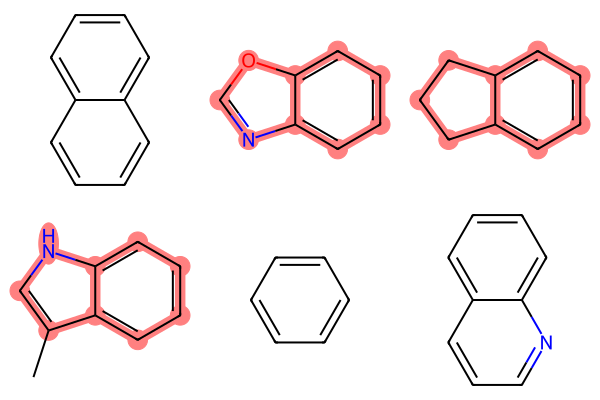

In [17]:
highlight_lists = [mol.GetSubstructMatch(benzo_five) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, 
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

The graph above shows that skatole, indane, and benzoxazole hit our first query, which tested whether a molecule contained a benzene fused to a five-membered ring.  The skatole example illustrates that not all atoms in a molecule need to match a query, and also that only those atoms that match will be highlighted.

As expected, benzene isn't highlighted because it doesn't contain two rings, and naphthalene and quinoline aren't highlighted because they contain benzene fused to a _six_-membered ring. 

# Showing the hits: six-membered rings fused to benzene
The other query was to check for benzene fused to six-membered rings.  This should hit naphthalene and quinoline.  

In [18]:
for mol in my_molecules:
    AllChem.GenerateDepictionMatching2DStructure(mol, benzo_six, acceptFailure = True)

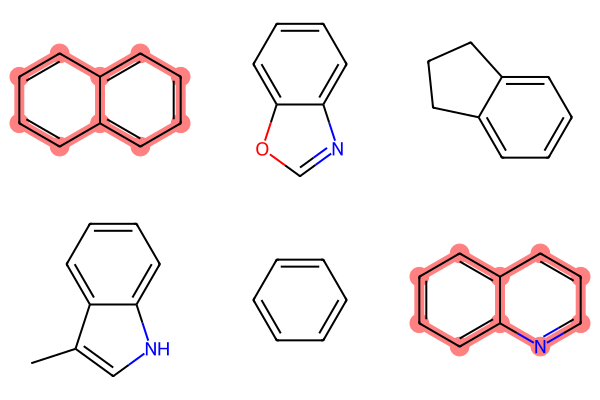

In [19]:
# make sure the molecules are storing information about the SSS match:
highlight_lists = [mol.GetSubstructMatch(benzo_six) for mol in my_molecules]
Draw.MolsToGridImage(my_molecules, 
                     highlightAtomLists = highlight_lists,
                     useSVG=False
                    )

tutorial author: Curt Fischer, Oct. 2016